In [ ]:
import numpy as np
import random

# Ensure GPU is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[]

In [ ]:
from tensorflow.keras.models import load_model


model_paths = {
    'Model_1': 'CNN.h5',
    'Model_2': 'best_model_combined_PlusOnly.h5',
    'Model_3': 'connect4_cnn_model.h5',
    'Model_4': 'cnn_model_feb10_merged_data_80epoch.h5',
    'Model_5': 'connect4_cnn_2channel.h5'
}



models = {name: load_model(path) for name, path in model_paths.items()}


In [ ]:
ROWS, COLS = 6, 7

def create_board():
    return np.zeros((ROWS, COLS), dtype=int)

def get_valid_moves(board):
    return [c for c in range(COLS) if board[0][c] == 0]

def drop_piece(board, row, col, player):
    board[int(row)][int(col)] = player

def get_next_open_row(board, col):
    col = int(col)  # ensure col is integer
    for r in reversed(range(ROWS)):
        if board[r][col] == 0:
            return r

def winning_move(board, player):
    for c in range(COLS - 3):
        for r in range(ROWS):
            if all(board[r][c+i] == player for i in range(4)):
                return True
    for c in range(COLS):
        for r in range(ROWS - 3):
            if all(board[r+i][c] == player for i in range(4)):
                return True
    for c in range(COLS - 3):
        for r in range(ROWS - 3):
            if all(board[r+i][c+i] == player for i in range(4)):
                return True
    for c in range(COLS - 3):
        for r in range(3, ROWS):
            if all(board[r-i][c+i] == player for i in range(4)):
                return True
    return False


In [ ]:
for name, model in models.items():
    print(f"{name} input shape: {model.input_shape}")


Model_1 input shape: (None, 6, 7, 2)
Model_2 input shape: (None, 6, 7, 2)
Model_3 input shape: (None, 6, 7, 2)
Model_4 input shape: (None, 6, 7, 2)
Model_5 input shape: (None, 6, 7, 2)


In [ ]:
def init_board():
    return create_board()

def apply_action(board, col, player):
    board = board.copy()
    row = get_next_open_row(board, col)
    if row is not None:
        drop_piece(board, row, col, player)
    return board

def check_winner(board):
    if winning_move(board, 1):
        return 1
    elif winning_move(board, 2):
        return 2
    else:
        return 0

def game_over(board):
    return winning_move(board, 1) or winning_move(board, 2) or len(get_valid_moves(board)) == 0


def preprocess_board(board, player):
    board_input = np.zeros((2, 6, 7))
    board_input[0] = (board == player)
    board_input[1] = (board == 3 - player)
    return board_input.transpose(1, 2, 0)  # shape: (6, 7, 2)

In [ ]:

from collections import deque
import tensorflow as tf

# Hyperparameters
gamma = 0.99
batch_size = 128
optimizer = tf.keras.optimizers.Adam(1e-3)

# Storage for PG training
pg_training_data = []

# --- M1: Probabilistic sampling based on model ---
def sample_model_move(model, board, player):
    """Sample move based on softmax probs, only legal moves."""
    board_input = np.zeros((2, 6, 7))
    board_input[0] = (board == player)
    board_input[1] = (board == 3 - player)
    input_tensor = board_input.transpose(1, 2, 0).reshape(1, 6, 7, 2)

    preds = model.predict(input_tensor, verbose=0)[0]
    valid_moves = get_valid_moves(board)

    # Mask out invalid moves
    probs = np.array([preds[i] if i in valid_moves else 0 for i in range(7)])
    probs /= np.sum(probs)
    return np.random.choice(7, p=probs), preds  # returns action, full probs

# --- M2: Strong logic with win / block / fallback ---
def get_m2_move(model, board, player):
    valid_moves = get_valid_moves(board)
    opponent = 3 - player

    # 1. Winning move
    for move in valid_moves:
        test_board = board.copy()
        test_board = apply_action(test_board, move, player)
        if check_winner(test_board) == player:
            return move

    # 2. Block opponent's win
    for move in valid_moves:
        test_board = board.copy()
        test_board = apply_action(test_board, move, opponent)
        if check_winner(test_board) == opponent:
            return move

    # 3. Fallback: softmax sampling
    return sample_model_move(model, board, player)[0]


def play_game(model1, model2, first_player):
    board = create_board()
    player_turn = 1 if first_player == 1 else 2
    model_map = {1: model1, 2: model2}

    while True:
        model = model_map[player_turn]

        if model == model1:
            move, _ = sample_model_move(model1, board, player_turn)
        else:
            move = get_m2_move(model2, board, player_turn)  # use stronger logic for opponent

        move = int(move) if not isinstance(move, int) else move

        row = int(get_next_open_row(board, move))
        drop_piece(board, row, move, player_turn)

        if winning_move(board, player_turn):
            return player_turn  # model1 = 1, model2 = 2

        if len(get_valid_moves(board)) == 0:
            return 0  # Draw

        player_turn = 3 - player_turn  # Switch player

# --- Preprocess board for storage ---
def preprocess_board(board, player):
    board_input = np.zeros((2, 6, 7))
    board_input[0] = (board == player)
    board_input[1] = (board == 3 - player)
    return board_input.transpose(1, 2, 0)  # shape (6,7,2)

# --- One game simulation with random opening and data collection ---
def simulate_pg_game(M1, M2, gamma=0.99):
    board = init_board()
    current_player = random.choice([1, 2])
    models = {1: M1, 2: M2}
    m1_episode = []

    # Random opening moves
    for _ in range(random.randint(2, 4)):
        valid_moves = get_valid_moves(board)
        if not valid_moves: break
        action = random.choice(valid_moves)
        board = apply_action(board, action, current_player)
        current_player = 3 - current_player

    reward_array = []
    while not game_over(board):
        model = models[current_player]
        board_state = preprocess_board(board, current_player)

        if model == M1:
            action, _ = sample_model_move(M1, board, current_player)
            m1_episode.append((board_state, action))
            reward_array.append(0)
        else:
            action = get_m2_move(M2, board, current_player)

        board = apply_action(board, action, current_player)

        current_player = 3 - current_player

    # Final reward
    winner = check_winner(board)
    # print ('Winner is ', winner)
    final_reward = 1 if winner == 1 else -1 if winner == 2 else 0
    if reward_array:
        reward_array[-1] = final_reward

    # print("M1 took", len(m1_episode), "steps")
    # print("Debug inside simulate_pg; Reward array :", reward_array)

    return [(s, a, r) for (s, a), r in zip(m1_episode, reward_array)]

def compute_discounted_rewards(rewards, gamma=0.99):
    G = 0
    discounted = []
    for r in reversed(rewards):
        G = r + gamma * G
        discounted.insert(0, G)
    return discounted

def normalize(rewards):
    rewards = np.array(rewards)
    return (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)

In [ ]:
## reinforce training function

def reinforce_train(model, triplets, optimizer=tf.keras.optimizers.Adam(1e-3)):
    states, actions, rewards = zip(*triplets)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards).astype(np.float32)
    # print(rewards)
    with tf.GradientTape() as tape:
        logits = model(states, training=True)
        action_probs = tf.nn.softmax(logits)

        # Gather log probs of selected actions
        indices = tf.range(len(actions))

        picked_action_probs = tf.gather_nd(action_probs, tf.stack([indices, actions], axis=1))
        # print("Sample picked probs:", picked_action_probs.numpy()[:10])
        log_probs = tf.math.log(picked_action_probs + 1e-10)

        loss = -tf.reduce_sum(log_probs * rewards) / len(rewards)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print(f" PG Loss: {loss.numpy():.6f}")
    return loss.numpy()

In [ ]:
def evaluate_m1(model, opponents, games_per_opponent=10):
    results = []

    for name, opp in opponents.items():

        try:
            if opp.input_shape[-1] != model.input_shape[-1]:
                print(f" Skipping {name}: incompatible input shape")
                continue
        except Exception as e:
            print(f" Error checking {name}: {e}")
            continue

        wins, losses, draws = 0, 0, 0
        for _ in range(games_per_opponent):
            first_player = random.choice([1, 2])
            try:
                winner = play_game(model, opp, first_player)
            except Exception as e:
                print(f" Skipping game vs {name}: {e}")
                continue

            if winner == 1:
                wins += 1
            elif winner == 2:
                losses += 1
            else:
                draws += 1

        results.append({
            'opponent': name,
            'wins': wins,
            'losses': losses,
            'draws': draws,
            'win_rate': wins / games_per_opponent
        })

    return results

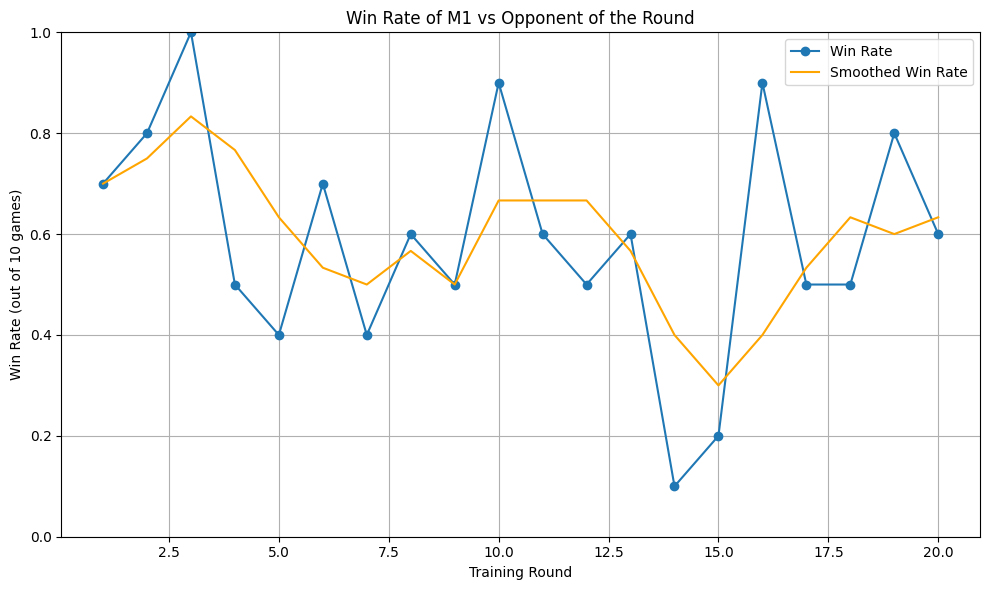

🔁 Round 21: M1 vs M1_clone_round20


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output


import os
evaluation_results = []
loss_history = []
episodes_per_batch = 50
episode_buffer = []

# Create a directory to store saved models
os.makedirs("m1_snapshots", exist_ok=True)

# Choose M1 to train
M1 = models['Model_3']
m1_clones = []

# PG Training loop
for round in range(200):

    # Save + clone every 5 rounds
    if (round + 1) % 5 == 0:
        new_model_name = f"M1_clone_round{round+1}"

        model_path = f"m1_snapshots/M1_round{round+1}.h5"
        M1.save(model_path)
        print(f"Saved M1 snapshot to {model_path}")
        m1_clones.append(new_model_name)

        if len(m1_clones) > 3:
            old_clone = m1_clones.pop(0)
            del models[old_clone]

        M1_clone = tf.keras.models.clone_model(M1)
        M1_clone.set_weights(M1.get_weights())
        models[new_model_name] = M1_clone
        print(f"Added {new_model_name} to opponent pool")

    # Pick a compatible opponent
    while True:

        available_opponents = [name for name in models.keys() if name != 'Model_3']
        M2_name = random.choice(available_opponents)
        M2 = models[M2_name]
        if M2.input_shape[-1] == 2:
            break
        else:
            print(f"⏭Skipping {M2_name} (expects {M2.input_shape[-1]} channels)")

    print(f"Round {round+1}: M1 vs {M2_name}")

    for _ in range(episodes_per_batch):
        episode = simulate_pg_game(M1, M2)  # full episode with rewards
        episode_buffer.append(episode)

    # Flatten episodes into a single triplet list and train
    all_triplets = []
    for episode in episode_buffer:
        states, actions, rewards = zip(*episode)
        # print('Rewards - ', rewards)
        discounted = compute_discounted_rewards(rewards)
        # print('Discounted - ', discounted)
        # normalized = normalize(discounted)
        all_triplets.extend([(s, a, r) for s, a, r in zip(states, actions, discounted)])

    print(f"Training on {len(all_triplets)} total triplets from {episodes_per_batch} episodes")

    loss = reinforce_train(M1, all_triplets)
    loss_history.append((round + 1, loss))

    episode_buffer = []
    print(f"Trained M1 on {batch_size} samples")

    #  Evaluate on the current opponent only
    eval_result = evaluate_m1(M1, {M2_name: M2}, games_per_opponent=10)[0]
    eval_result['round'] = round + 1
    evaluation_results.append(eval_result)

    # Live win-rate plot (single series)
    import pandas as pd
    import matplotlib.pyplot as plt
    from IPython.display import clear_output

    eval_df = pd.DataFrame(evaluation_results)
    clear_output(wait=True)

    eval_df['smoothed'] = eval_df['win_rate'].rolling(window=3, min_periods=1).mean()


    plt.figure(figsize=(10, 6))
    plt.plot(eval_df['round'], eval_df['win_rate'], label = 'Win Rate',  marker='o')
    plt.plot(eval_df['round'], eval_df['smoothed'], label='Smoothed Win Rate', color='orange')
    plt.title("Win Rate of M1 vs Opponent of the Round")
    plt.xlabel("Training Round")
    plt.ylabel("Win Rate (out of 10 games)")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
loss_df = pd.DataFrame(loss_history, columns=['round', 'loss'])
plt.plot(loss_df['round'], loss_df['loss'])
plt.title("Training Loss over Rounds")
plt.xlabel("Round")
plt.ylabel("PG Loss")
plt.grid(True)
plt.show()

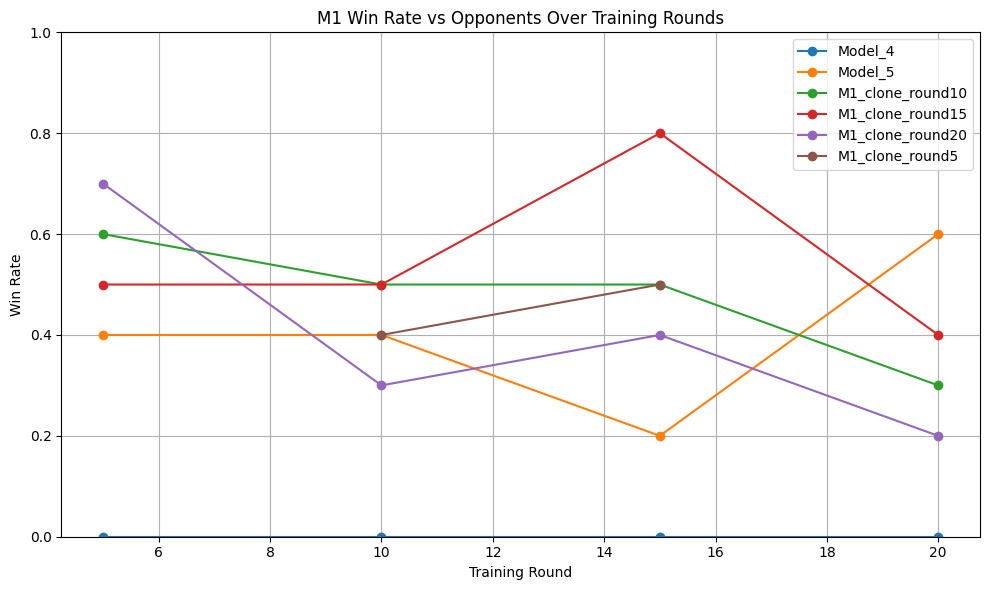

In [ ]:
import pandas as pd

eval_df = pd.DataFrame(evaluation_results)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for opponent in eval_df['opponent'].unique():
    df_subset = eval_df[eval_df['opponent'] == opponent]
    plt.plot(df_subset['round'], df_subset['win_rate'], marker='o', label=opponent)

plt.title("M1 Win Rate vs Opponents Over Training Rounds")
plt.xlabel("Training Round")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Policy Gradient with MCTS

In [ ]:
import copy
import numpy as np

def get_mcts_move(board, player, simulations=1000):
    """Run MCTS simulations and pick the move with highest win rate."""
    win_counts = {move: 0 for move in get_valid_moves(board)}

    for _ in range(simulations):
        # Copy board for simulation
        sim_board = copy.deepcopy(board)
        sim_player = player

        # Choose a random valid move to start
        possible_moves = get_valid_moves(sim_board)
        move = random.choice(possible_moves)

        # Apply the move
        row = get_next_open_row(sim_board, move)
        drop_piece(sim_board, row, move, sim_player)

        # Simulate rest of game randomly
        winner = simulate_random_game(sim_board, 3 - sim_player)

        if winner == player:
            win_counts[move] += 1

    # Pick the move with maximum win count
    best_move = max(win_counts, key=win_counts.get)
    return best_move

def simulate_random_game(board, current_player):
    """Simulate a random game from current state."""
    while not game_over(board):
        valid_moves = get_valid_moves(board)
        move = random.choice(valid_moves)
        row = get_next_open_row(board, move)
        drop_piece(board, row, move, current_player)
        if winning_move(board, current_player):
            return current_player
        current_player = 3 - current_player  # Switch players

    return 0  # Draw


def simulate_pg_game_with_mcts(M1, simulations=1000, gamma=0.99):
    board = init_board()
    current_player = random.choice([1, 2])
    m1_episode = []
    reward_array = []

    # Random opening moves (2 to 4 moves)
    for _ in range(random.randint(2, 4)):
        valid_moves = get_valid_moves(board)
        if not valid_moves:
            break
        action = random.choice(valid_moves)
        board = apply_action(board, action, current_player)
        current_player = 3 - current_player

    # 🎮 Main gameplay
    while not game_over(board):
        board_state = preprocess_board(board, current_player)

        if current_player == 1:
            #  M1's move
            action, _ = sample_model_move(M1, board, current_player)
            m1_episode.append((board_state, action))
            reward_array.append(0)
        else:
            #  MCTS's move
            action = get_mcts_move(board, player=current_player, simulations=simulations)

        board = apply_action(board, action, current_player)
        current_player = 3 - current_player

    # 🏁 Game finished, assign final reward
    winner = check_winner(board)
    final_reward = 1 if winner == 1 else -1 if winner == 2 else 0

    if reward_array:
        reward_array[-1] = final_reward  # Only last action gets reward

    return [(s, a, r) for (s, a), r in zip(m1_episode, reward_array)]

def play_vs_mcts_eval(M1, simulations=1000):
    board = init_board()
    current_player = 1  # Always M1 starts
    while not game_over(board):
        if current_player == 1:
            state = preprocess_board(board, player=1)
            action_probs = M1.predict(state[np.newaxis, ...], verbose=0)[0]
            valid_moves = get_valid_moves(board)
            masked_probs = [action_probs[i] if i in valid_moves else -np.inf for i in range(7)]
            move = int(np.argmax(masked_probs))
        else:
            move = get_mcts_move(board, player=2, simulations=simulations)

        row = get_next_open_row(board, move)
        drop_piece(board, row, move, current_player)

        if winning_move(board, current_player):
            return current_player

        current_player = 3 - current_player  # Switch turns

    return 0  # Draw

In [ ]:
def play_vs_mcts_eval(M1, simulations=1000):
    board = init_board()
    current_player = 1  # Always M1 starts
    while not game_over(board):
        if current_player == 1:
            state = preprocess_board(board, player=1)
            action_probs = M1.predict(state[np.newaxis, ...], verbose=0)[0]
            valid_moves = get_valid_moves(board)
            masked_probs = [action_probs[i] if i in valid_moves else -np.inf for i in range(7)]
            move = int(np.argmax(masked_probs))
        else:
            move = get_mcts_move(board, player=2, simulations=simulations)

        row = get_next_open_row(board, move)
        drop_piece(board, row, move, current_player)

        if winning_move(board, current_player):
            return current_player

        current_player = 3 - current_player  # Switch turns

    return 0  # Draw

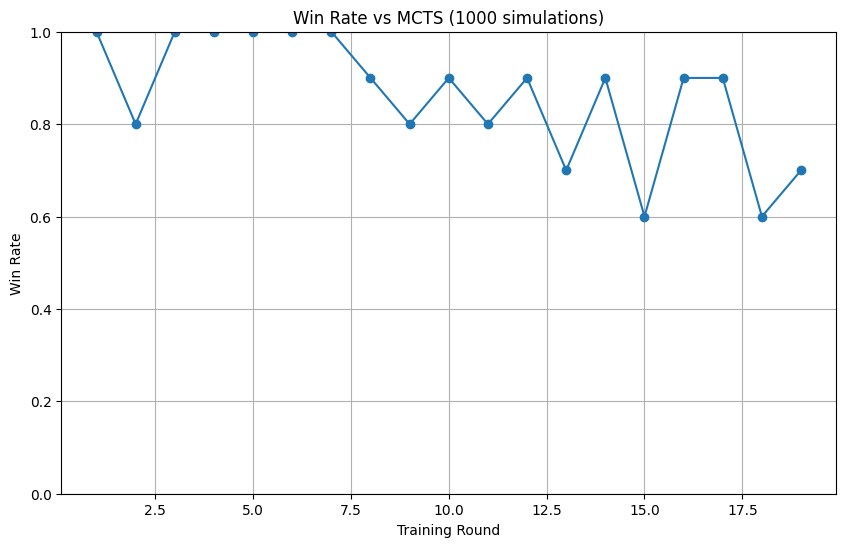

In [ ]:
import pandas as pd
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt


evaluation_results = []

episodes_per_batch = 10
episode_buffer = []

# Create save dir
os.makedirs("m1_snapshots", exist_ok=True)

# Initialize M1 (your winning model)
M1 = models['Model_3']

# PG Training Loop vs MCTS
for round in range(20):

    # Play vs MCTS instead of another model
    for _ in range(episodes_per_batch):
        episode = simulate_pg_game_with_mcts(M1, simulations=1000)  # <-- New
        episode_buffer.append(episode)

    # Flatten episodes into triplets
    all_triplets = []
    for episode in episode_buffer:
        states, actions, rewards = zip(*episode)
        discounted = compute_discounted_rewards(rewards)
        normalized = normalize(discounted)
        all_triplets.extend([(s, a, r) for s, a, r in zip(states, actions, normalized)])

    reinforce_train(M1, all_triplets)
    episode_buffer = []
    print(f" Trained M1 on {len(all_triplets)} samples")

    # Evaluation (optional, vs MCTS greedy moves)
    win_count = 0
    for _ in range(10):
        winner = play_vs_mcts_eval(M1, simulations=1000)
        if winner == 1:
            win_count += 1

    win_rate = win_count / 10
    evaluation_results.append({'round': round+1, 'win_rate': win_rate})

    # Live plot
    eval_df = pd.DataFrame(evaluation_results)
    clear_output(wait=True)
    plt.figure(figsize=(10,6))
    plt.plot(eval_df['round'], eval_df['win_rate'], marker='o')
    plt.title('Win Rate vs MCTS (1000 simulations)')
    plt.xlabel('Training Round')
    plt.ylabel('Win Rate')
    plt.ylim(0,1)
    plt.grid(True)
    plt.show()



In [ ]:
model_path = f"m1_snapshots/M1_round{round+1}.h5"
M1.save(model_path)

### DDQN

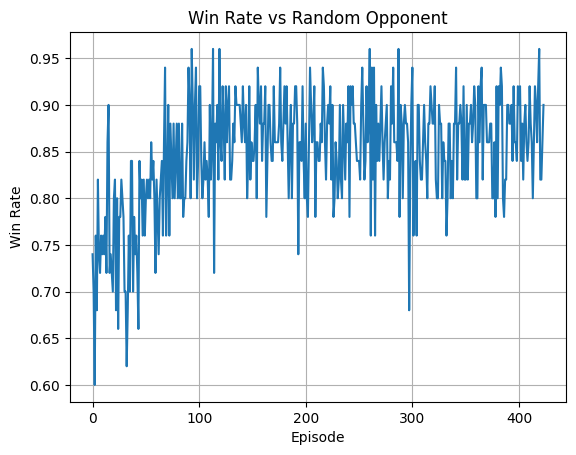

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
import random
from collections import deque
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output


# --- DQN model builder ---
def build_q_network():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,7,2)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(7)  # Q-values for 7 columns
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    return model

# --- Hyperparameters ---
memory = deque(maxlen=50000)
batch_size = 64
gamma = 0.99
epsilon = 0.5
min_epsilon = 0.05
epsilon_decay = 0.90
update_target_freq = 10  # episodes
train_freq = 5           # episodes
episodes = 500

# --- Initialize networks ---
q_net = build_q_network()
target_q_net = build_q_network()
target_q_net.set_weights(q_net.get_weights())

# --- Move selector ---
def select_action(model, board, player, epsilon):
    if np.random.rand() < epsilon:
        return random.choice(get_valid_moves(board))
    state = preprocess_board(board, player)
    q_vals = model.predict(state[np.newaxis, ...], verbose=0)[0]
    valid_moves = get_valid_moves(board)
    masked_q = [q_vals[i] if i in valid_moves else -np.inf for i in range(7)]
    return int(np.argmax(masked_q))

# --- Experience replay trainer ---
def train_from_memory():
    if len(memory) < batch_size:
        return

    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states)
    next_states = np.array(next_states)

    q_values = q_net.predict(states, verbose=0)
    q_next_online = q_net.predict(next_states, verbose=0)
    q_next_target = target_q_net.predict(next_states, verbose=0)

    for i in range(batch_size):
        if dones[i]:
            q_values[i][actions[i]] = rewards[i]
        else:
            # Double DQN update!
            best_next_action = np.argmax(q_next_online[i])
            q_values[i][actions[i]] = rewards[i] + gamma * q_next_target[i][best_next_action]

    q_net.fit(states, q_values, epochs=1, verbose=0)

# --- Training loop ---
win_rates = []
os.makedirs("dqn_snapshots", exist_ok=True)

for ep in range(episodes):
    board = create_board()
    current_player = random.choice([1,2])

    # Random opening moves
    for _ in range(random.randint(2, 4)):
        valid_moves = get_valid_moves(board)
        if not valid_moves:
            break
        action = random.choice(valid_moves)
        row = get_next_open_row(board, action)
        drop_piece(board, row, action, current_player)
        current_player = 3 - current_player

    # Game simulation
    state_stack = []
    reward_stack = []

    while not game_over(board):
        if current_player == 1:
            state = preprocess_board(board, player=1)
            action = select_action(q_net, board, player=1, epsilon=epsilon)
            next_board = np.copy(board)
            row = get_next_open_row(next_board, action)
            drop_piece(next_board, row, action, current_player)

            reward = 0
            if winning_move(next_board, current_player):
                reward = 1
            elif len(get_valid_moves(next_board)) == 0:
                reward = 0.5  # Draw
            elif winning_move(next_board, 3 - current_player):
                reward = -1

            done = game_over(next_board)
            memory.append((state, action, reward, preprocess_board(next_board, player=1), done))
            board = next_board

        else:
            # Opponent: random
            valid_moves = get_valid_moves(board)
            if not valid_moves:
                break
            action = random.choice(valid_moves)
            row = get_next_open_row(board, action)
            drop_piece(board, row, action, current_player)

        current_player = 3 - current_player

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Train after every game
    if ep % train_freq == 0:
        train_from_memory()

    # Update target net
    if ep % update_target_freq == 0:
        target_q_net.set_weights(q_net.get_weights())
        print(f" Target net synced at episode {ep}")

    # Save snapshots
    if ep % 100 == 0:
        q_net.save(f"dqn_snapshots/dqn_ep{ep}.h5")
        print(f"Saved DQN model at episode {ep}")

    # Evaluation
    win = 0
    for _ in range(50):
        test_board = create_board()
        player = 1
        while not game_over(test_board):
            if player == 1:
                action = select_action(q_net, test_board, player=1, epsilon=0.0)
            else:
                action = random.choice(get_valid_moves(test_board))
            row = get_next_open_row(test_board, action)
            drop_piece(test_board, row, action, player)
            if winning_move(test_board, player):
                break
            player = 3 - player
        if winning_move(test_board, 1):
            win += 1

    win_rate = win / 50
    win_rates.append(win_rate)

    clear_output(wait=True)
    plt.plot(win_rates)
    plt.title('Win Rate vs Random Opponent')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.grid()
    plt.show()

## Comparing DDQN & PGs

In [ ]:
import tensorflow as tf
import numpy as np
import random

# Load models
pg_model = tf.keras.models.load_model('/content/m1_snapshots/M1_round20.h5')
ddqn_model = tf.keras.models.load_model('/content/dqn_snapshots/dqn_ep400.h5', compile=False)


# Model moves
def pg_model_move(model, board, player):
    input_tensor = preprocess_board(board, player).reshape(1, 6, 7, 2)
    preds = model.predict(input_tensor, verbose=0)[0]

    valid_moves = get_valid_moves(board)
    probs = np.array([preds[i] if i in valid_moves else 0 for i in range(7)])
    if np.sum(probs) == 0:
        return random.choice(valid_moves)
    probs /= np.sum(probs)
    return np.random.choice(7, p=probs)

def ddqn_model_move(model, board, player):
    input_tensor = preprocess_board(board, player).reshape(1, 6, 7, 2)
    q_vals = model.predict(input_tensor, verbose=0)[0]

    valid_moves = get_valid_moves(board)
    masked_q = [q_vals[i] if i in valid_moves else -np.inf for i in range(7)]
    return int(np.argmax(masked_q))

# Play one full game
def play_pg_vs_ddqn(pg_model, ddqn_model, first_player):
    board = create_board()
    player_turn = 1 if first_player == 1 else 2
    models = {1: pg_model, 2: ddqn_model}

    while not game_over(board):
        if player_turn == 1:
            move = pg_model_move(models[1], board, player_turn)
        else:
            move = ddqn_model_move(models[2], board, player_turn)

        row = get_next_open_row(board, move)
        drop_piece(board, row, move, player_turn)

        if winning_move(board, player_turn):
            return player_turn  # Return winner
        if len(get_valid_moves(board)) == 0:
            return 0  # Draw

        player_turn = 3 - player_turn

# Now run 500 games
num_games = 500
pg_wins, ddqn_wins, draws = 0, 0, 0

for _ in range(num_games):
    first_player = random.choice([1, 2])
    winner = play_pg_vs_ddqn(pg_model, ddqn_model, first_player)

    if winner == 1:
        pg_wins += 1
    elif winner == 2:
        ddqn_wins += 1
    else:
        draws += 1

print(f" Results after {num_games} games:")
print(f"PG Wins: {pg_wins}")
print(f"DDQN Wins: {ddqn_wins}")
print(f"Draws: {draws}")

pg_winrate = pg_wins / num_games
ddqn_winrate = ddqn_wins / num_games
draw_rate = draws / num_games

print(f"\nPG Win Rate: {pg_winrate:.2%}")
print(f"DDQN Win Rate: {ddqn_winrate:.2%}")
print(f"Draw Rate: {draw_rate:.2%}")

🏆 Results after 500 games:
PG Wins: 500
DDQN Wins: 0
Draws: 0

PG Win Rate: 100.00%
DDQN Win Rate: 0.00%
Draw Rate: 0.00%


## Actor Critic

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['critic/kernel', 'critic/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Episode 10, Avg Loss: 0.6539, Win Rate: 40.00%
Episode 20, Avg Loss: 2.2636, Win Rate: 80.00%
Episode 30, Avg Loss: 2.2398, Win Rate: 80.00%
Episode 40, Avg Loss: 1.7858, Win Rate: 70.00%
Episode 50, Avg Loss: 0.6242, Win Rate: 40.00%
Episode 60, Avg Loss: 1.4032, Win Rate: 60.00%
Episode 70, Avg Loss: 1.4704, Win Rate: 60.00%
Episode 80, Avg Loss: 1.0451, Win Rate: 50.00%
Episode 90, Avg Loss: 1.8448, Win Rate: 70.00%
Episode 100, Avg Loss: 2.5367, Win Rate: 90.00%
Episode 110, Avg Loss: 2.5573, Win Rate: 90.00%
Episode 120, Avg Loss: 0.6734, Win Rate: 40.00%
Episode 130, Avg Loss: 1.8458, Win Rate: 70.00%
Episode 140, Avg Loss: 1.7910, Win Rate: 70.00%
Episode 150, Avg Loss: 0.6291, Win Rate: 40.00%
Episode 160, Avg Loss: 1.0429, Win Rate: 50.00%
Episode 170, Avg Loss: 1.4421, Win Rate: 60.00%
Episode 180, Avg Loss: 1.9340, Win Rate: 70.00%
Episode 190, Avg Loss: 1.8439, Win Rate: 70.00%
Episode 200, Avg Loss: 1.3908, Win Rate: 60.00%
Episode 210, Avg Loss: 2.1899, Win Rate: 80.00%
E

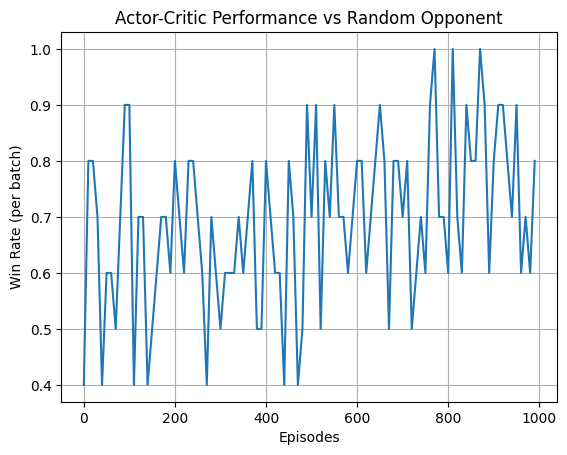

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from collections import deque


# Build Actor-Critic network
def build_actor_critic():
    inputs = tf.keras.Input(shape=(6, 7, 2))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    actor_output = tf.keras.layers.Dense(7, activation='softmax', name='actor')(x)
    critic_output = tf.keras.layers.Dense(1, name='critic')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[actor_output, critic_output])
    return model

model = build_actor_critic()

optimizer = tf.keras.optimizers.Adam(1e-4)
gamma = 0.99

# Opponent: random
def random_opponent_move(board):
    return random.choice(get_valid_moves(board))

# Actor-Critic move
def select_ac_action(model, board, player):
    state = preprocess_board(board, player).reshape(1, 6, 7, 2)
    action_probs, _ = model(state, training=False)
    action_probs = action_probs.numpy()[0]

    valid_moves = get_valid_moves(board)
    probs = np.array([action_probs[i] if i in valid_moves else 0 for i in range(7)])
    if np.sum(probs) == 0:
        return random.choice(valid_moves)
    probs /= np.sum(probs)

    return np.random.choice(7, p=probs)

# Simulate one episode
def play_one_game(model):
    board = create_board()
    player_turn = 1
    memory = []

    while not game_over(board):
        if player_turn == 1:
            move = select_ac_action(model, board, player_turn)
        else:
            move = random_opponent_move(board)

        row = get_next_open_row(board, move)
        drop_piece(board, row, move, player_turn)

        if player_turn == 1:
            state = preprocess_board(board, 1)
            memory.append((state, move))

        if winning_move(board, player_turn):
            return memory, 1 if player_turn == 1 else -1  # reward +1 if agent wins, -1 if opponent wins

        if len(get_valid_moves(board)) == 0:
            return memory, 0  # Draw

        player_turn = 3 - player_turn

    return memory, 0

# Discount rewards
def compute_discounted_rewards(reward, steps, gamma=0.99):
    discounted = np.zeros(steps)
    R = reward
    for t in reversed(range(steps)):
        discounted[t] = R
        R = gamma * R
    return discounted

# Training step
def train_ac(model, optimizer, memory, final_reward):
    states, actions = zip(*memory)
    states = np.array(states)
    actions = np.array(actions)

    discounted_rewards = tf.convert_to_tensor(
    compute_discounted_rewards(final_reward, len(memory)),
    dtype=tf.float32
    )

    with tf.GradientTape() as tape:
        action_probs, state_values = model(states, training=True)
        state_values = tf.squeeze(state_values)

        indices = np.array([[i, a] for i, a in enumerate(actions)])
        selected_action_probs = tf.gather_nd(action_probs, indices)

        advantages = discounted_rewards - state_values.numpy()

        actor_loss = -tf.reduce_mean(tf.math.log(selected_action_probs + 1e-8) * advantages)
        critic_loss = tf.reduce_mean(tf.square(advantages))
        total_loss = actor_loss + critic_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss.numpy()

# Main training loop
episodes = 1000
batch_size = 10

losses = []
win_rates = []
wins = 0

for episode in range(episodes):
    memory, final_reward = play_one_game(model)

    if final_reward == 1:
        wins += 1

    loss = train_ac(model, optimizer, memory, final_reward)
    losses.append(loss)

    if (episode + 1) % batch_size == 0:
        win_rate = wins / batch_size
        print(f"Episode {episode+1}, Avg Loss: {np.mean(losses[-batch_size:]):.4f}, Win Rate: {win_rate:.2%}")
        win_rates.append(win_rate)
        wins = 0

# Plotting Win Rates
plt.plot(np.arange(len(win_rates)) * batch_size, win_rates)
plt.xlabel('Episodes')
plt.ylabel('Win Rate (per batch)')
plt.title('Actor-Critic Performance vs Random Opponent')
plt.grid()
plt.show()

In [ ]:
model.save("actor_critic_connect4.h5")

In [ ]:
pg_model = tf.keras.models.load_model('/content/m1_snapshots/M1_round20.h5', compile=False)
ddqn_model = tf.keras.models.load_model('/content/dqn_snapshots/dqn_ep400.h5', compile=False)
ac_model = tf.keras.models.load_model('actor_critic_connect4.h5', compile=False)

In [ ]:
def select_pg_move(model, board, player):
    state = preprocess_board(board, player).reshape(1, 6, 7, 2)
    probs = model.predict(state, verbose=0)[0]
    valid_moves = get_valid_moves(board)
    masked_probs = np.array([probs[i] if i in valid_moves else 0 for i in range(7)])
    if masked_probs.sum() == 0:
        return random.choice(valid_moves)
    masked_probs /= masked_probs.sum()
    return np.random.choice(7, p=masked_probs)

def select_ddqn_move(model, board, player):
    state = preprocess_board(board, player).reshape(1, 6, 7, 2)
    q_values = model.predict(state, verbose=0)[0]
    valid_moves = get_valid_moves(board)
    masked_q = np.array([q_values[i] if i in valid_moves else -np.inf for i in range(7)])
    return int(np.argmax(masked_q))

def select_ac_move(model, board, player):
    state = preprocess_board(board, player).reshape(1, 6, 7, 2)
    action_probs, _ = model.predict(state, verbose=0)
    probs = action_probs[0]
    valid_moves = get_valid_moves(board)
    masked_probs = np.array([probs[i] if i in valid_moves else 0 for i in range(7)])
    if masked_probs.sum() == 0:
        return random.choice(valid_moves)
    masked_probs /= masked_probs.sum()
    return np.random.choice(7, p=masked_probs)

In [ ]:
def play_connect4(model1, model2, move_func1, move_func2):
    board = create_board()
    current_player = 1

    while not game_over(board):
        if current_player == 1:
            move = move_func1(model1, board, current_player)
        else:
            move = move_func2(model2, board, current_player)

        row = get_next_open_row(board, move)
        drop_piece(board, row, move, current_player)

        if winning_move(board, current_player):
            return current_player
        if len(get_valid_moves(board)) == 0:
            return 0  # Draw

        current_player = 3 - current_player  # Switch turns

In [ ]:
def compare_models(model1, model2, move_func1, move_func2, num_games=500):
    wins1 = 0
    wins2 = 0
    draws = 0

    for _ in range(num_games):
        first_player = random.choice([1, 2])
        if first_player == 1:
            winner = play_connect4(model1, model2, move_func1, move_func2)
        else:
            winner = play_connect4(model2, model1, move_func2, move_func1)
            if winner == 1:
                winner = 2
            elif winner == 2:
                winner = 1

        if winner == 1:
            wins1 += 1
        elif winner == 2:
            wins2 += 1
        else:
            draws += 1

    print(f"Model 1 Wins: {wins1} / {num_games}")
    print(f"Model 2 Wins: {wins2} / {num_games}")
    print(f"Draws: {draws} / {num_games}")

In [ ]:
compare_models(ddqn_model, ac_model, select_ddqn_move, select_ac_move, num_games=500)

Model 1 Wins: 413 / 500
Model 2 Wins: 87 / 500
Draws: 0 / 500


In [ ]:
compare_models(pg_model, ac_model, select_pg_move, select_ac_move, num_games=500)

Model 1 Wins: 498 / 500
Model 2 Wins: 2 / 500
Draws: 0 / 500


In [ ]:
compare_models(pg_model, ddqn_model, select_pg_move, select_ddqn_move, num_games=500)

Model 1 Wins: 500 / 500
Model 2 Wins: 0 / 500
Draws: 0 / 500


## Playing with Human

In [3]:
import numpy as np
import tensorflow as tf

# --- Connect 4 Basics ---
ROWS, COLS = 6, 7

def create_board():
    return np.zeros((ROWS, COLS), dtype=int)

def print_board(board):
    print(board, 0)  # Flip vertically to match Connect 4 style

def get_valid_moves(board):
    return [c for c in range(COLS) if board[0][c] == 0]

def get_next_open_row(board, col):
    for r in reversed(range(ROWS)):
        if board[r][col] == 0:
            return r

def drop_piece(board, row, col, player):
    board[row][col] = player

def winning_move(board, player):
    # Horizontal
    for c in range(COLS - 3):
        for r in range(ROWS):
            if all(board[r][c+i] == player for i in range(4)):
                return True
    # Vertical
    for c in range(COLS):
        for r in range(ROWS - 3):
            if all(board[r+i][c] == player for i in range(4)):
                return True
    # Positive Diagonal
    for c in range(COLS - 3):
        for r in range(ROWS - 3):
            if all(board[r+i][c+i] == player for i in range(4)):
                return True
    # Negative Diagonal
    for c in range(COLS - 3):
        for r in range(3, ROWS):
            if all(board[r-i][c+i] == player for i in range(4)):
                return True
    return False

# --- Preprocess for model input ---
def preprocess_board(board, player):
    board_input = np.zeros((2, 6, 7))
    board_input[0] = (board == player)
    board_input[1] = (board == 3 - player)
    return board_input.transpose(1,2,0)  # Shape (6,7,2)

# --- Human vs Model Game ---
def play_human_vs_model(model_path):
    board = create_board()
    model = tf.keras.models.load_model(model_path)

    # Ask who goes first
    first_player = None
    while first_player not in ['human', 'model']:
        first_player = input("Who goes first? ('human' or 'model'): ").strip().lower()

    if first_player == 'human':
        human_player = 1
        model_player = 2
    else:
        human_player = 2
        model_player = 1

    player_turn = 1  # Always start with player 1

    while True:
        print_board(board)

        if player_turn == human_player:
            # Human's turn
            valid_moves = get_valid_moves(board)
            move = None
            while move not in valid_moves:
                try:
                    move = int(input(f"Your Move {valid_moves}: "))
                except ValueError:
                    move = None
            row = get_next_open_row(board, move)
            drop_piece(board, row, move, human_player)
        else:
            # Model's turn
            board_input = preprocess_board(board, model_player)
            preds = model.predict(board_input[np.newaxis, ...], verbose=0)[0]
            valid_moves = get_valid_moves(board)
            preds = np.array([preds[c] if c in valid_moves else -np.inf for c in range(7)])
            move = int(np.argmax(preds))
            row = get_next_open_row(board, move)
            drop_piece(board, row, move, model_player)
            print(f" Model played column {move}")

        # Check for win
        if winning_move(board, player_turn):
            print_board(board)
            if player_turn == human_player:
                print("You Win!")
            else:
                print(" Model Wins!")
            break

        # Check for draw
        if len(get_valid_moves(board)) == 0:
            print_board(board)
            print(" It's a draw!")
            break

        player_turn = 3 - player_turn  # Switch player

# --- Run the Game ---
play_human_vs_model("/content/M1_round20-2.h5")

Who goes first? ('human' or 'model'): human
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]] 0
Your Move [0, 1, 2, 3, 4, 5, 6]: 3
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]] 0
🤖 Model played column 3
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 1 0 0 0]] 0
Your Move [0, 1, 2, 3, 4, 5, 6]: 4
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 1 1 0 0]] 0
🤖 Model played column 2
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 2 1 1 0 0]] 0
Your Move [0, 1, 2, 3, 4, 5, 6]: 2
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0]
 [0 0 2 1 1 0 0]] 0
🤖 Model played column 3
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 1 2 0 0 0]
 [0 0 2 1 1 0 0]] 0
Your Move [0, 1, 2, 3, 4, 5, 6]: 3
[[0 0 0 0